In [ ]:
#!/usr/bin/env python3
"""
Universal Infectious Disease Simulator

Generates broad, diverse synthetic outbreaks by randomly drawing from wide
parameter ranges (transmission rates, super-spreading, wave changes, etc.).
You can call `generate_synthetic_dataset` many times to get thousands of
different "disease scenarios," all drawn from plausible intervals.

This is structured so that each run may produce a curve resembling something
"flu-like," "covid-like," or even more exotic, but all remain fairly realistic.

Feel free to adjust the default ranges for e.g. population size,
seasonality amplitude, wave changes, etc. to narrow or broaden the realism.
"""

import enum
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple, Any
import torch

#############################
# 1) Enums & Config        #
#############################

class SimulationType(enum.Enum):
    STANDARD = "standard"
    # You could add more if you wish


@dataclass
class UniversalDiseaseConfig:
    """
    Defines broad parameter ranges for a generic, respiratory, human-to-human disease.
    Each time you run the simulator, it will sample from these ranges to
    produce a unique outbreak scenario.
    """

    # Simulation horizon
    num_days: int = 2000

    # Whether or not to allow multiple waves (i.e. time-varying beta)
    multiple_waves: bool = True
    # number of wave changes (0..4 => up to 5 wave segments)
    wave_change_count_range: Tuple[int, int] = (0, 4)
    # valid day range for wave changes
    wave_day_min: int = 50
    wave_day_max: int = 1800

    # Population size (drawn log-uniformly)
    pop_size_min: float = 50000
    pop_size_max: float = 40_000_000

    # Transmission parameters
    beta_min: float = 0.2
    beta_max: float = 0.235
    gamma_min: float = 0.1   # ~1/10
    gamma_max: float = 0.33  # ~1/3

    # Latent period
    has_latent_prob: float = 0.7  # 70% of the time, we sample a latent compartment
    sigma_min: float = 0.2
    sigma_max: float = 0.4

    # Asymptomatic
    has_asymptomatic_prob: float = 0.5
    asymp_prob_beta: Tuple[float, float] = (3, 7)  # Beta(3,7) => ~30% mean
    asymp_trans_beta: Tuple[float, float] = (2, 5) # Beta(2,5) => ~<50% mean

    # Waning immunity
    has_waning_prob: float = 0.9
    omega_min: float = 0.001
    omega_max: float = 0.0075

    # Super-spreading
    super_spread_prob_min: float = 0.0005
    super_spread_prob_max: float = 0.02
    super_spread_shape: float = 4.0
    super_spread_scale: float = 1.5

    # Seasonality
    use_seasonality_prob: float = 0.8
    seasonality_num_harmonics_range: Tuple[int, int] = (1, 4)
    seasonality_amp_min: float = 0.1
    seasonality_amp_max: float = 0.5

    # Demographics (birth/death/import)
    enable_endemic_prob: float = 0.8
    birth_rate_min: float = 0.00002
    birth_rate_max: float = 0.00012
    death_rate_factor_min: float = 0.8
    death_rate_factor_max: float = 1.3
    importation_log_min: float = np.log(0.01)
    importation_log_max: float = np.log(0.5)

    # Intervention policy
    intervention_enable_prob: float = 0.25

    # Random seed for reproducibility (optional)
    random_seed: Optional[int] = None


#############################
# 2) Base Simulator        #
#############################

class BaseSimulator:
    """
    Base class that handles:
      - Population size randomization
      - Super-spreader parameter draws
      - (Optionally) seasonality with random harmonics
      - Demographic events if 'enable_endemic' is triggered
    """

    def __init__(self, config: UniversalDiseaseConfig):
        self.config = config

        # Optional random seed
        if config.random_seed is not None:
            random.seed(config.random_seed)
            np.random.seed(config.random_seed)

        # 1) Population
        pop_log_range = (np.log(config.pop_size_min), np.log(config.pop_size_max))
        self.Nh = int(np.exp(np.random.uniform(*pop_log_range)))

        # 2) Potentially random super-spreading
        self.super_spread_params = {
            'probability': np.random.uniform(config.super_spread_prob_min,
                                             config.super_spread_prob_max),
            'multiplier_shape': config.super_spread_shape,
            'multiplier_scale': config.super_spread_scale
        }

        # 3) Seasonality
        self._max_sim_days = config.num_days
        self._daily_noise = np.clip(np.random.normal(1.0, 0.05, self._max_sim_days), 0.5, 2.0)
        n_years = (self._max_sim_days // 365) + 2
        self._annual_peak_jitter = np.random.uniform(-30.0, 30.0, size=n_years)

        self._seasonal_harmonics = []
        self.use_seasonality = (random.random() < config.use_seasonality_prob)
        if self.use_seasonality:
            num_harmonics = np.random.randint(*config.seasonality_num_harmonics_range)
            base_amp = np.random.uniform(config.seasonality_amp_min, config.seasonality_amp_max)
            for _ in range(num_harmonics):
                frac = np.random.uniform(0.3, 1.0)
                amp = base_amp * frac
                offset = np.random.uniform(0, 365) + np.random.uniform(-60, 60)
                possible_periods = [365.0, 182.5, 91.25]
                period = np.random.choice(possible_periods)
                self._seasonal_harmonics.append((period, amp, offset))

        # 4) Endemic parameters
        self.endemic_params = {
            'enable_endemic': (random.random() < config.enable_endemic_prob),
            'birth_rate': 0.0,
            'death_rate': 0.0,
            'importation_rate': 0.0,
        }
        if self.endemic_params['enable_endemic']:
            birth_rate = np.random.uniform(config.birth_rate_min, config.birth_rate_max)
            factor = np.random.uniform(config.death_rate_factor_min, config.death_rate_factor_max)
            im_rate = np.exp(np.random.uniform(config.importation_log_min, config.importation_log_max))

            self.endemic_params['birth_rate'] = birth_rate
            self.endemic_params['death_rate'] = birth_rate * factor
            self.endemic_params['importation_rate'] = im_rate

    def _get_seasonal_factor(self, time: float) -> float:
        """Sum of cosines plus daily noise, clipped >= 0."""
        day_idx = int(np.floor(time))
        if day_idx < 0:
            day_idx = 0
        elif day_idx >= self._max_sim_days:
            day_idx = self._max_sim_days - 1

        year_idx = int(time // 365.0)
        if year_idx >= len(self._annual_peak_jitter):
            year_idx = len(self._annual_peak_jitter) - 1

        val = 1.0
        if self.use_seasonality:
            yearly_shift = self._annual_peak_jitter[year_idx]
            for (period, amp, offset) in self._seasonal_harmonics:
                val += amp * np.cos(2.0 * np.pi * ((time - offset - yearly_shift) / period))

        val *= self._daily_noise[day_idx]
        return max(0.0, val)

    def _apply_demographic_events(self, compartments: Dict[str, float]) -> Dict[str, float]:
        """Apply births into S and deaths proportionally, if endemic is enabled."""
        if not self.endemic_params['enable_endemic']:
            return compartments

        total_pop = sum(compartments.values())
        if total_pop <= 0:
            return compartments

        br = self.endemic_params['birth_rate']
        dr = self.endemic_params['death_rate']
        births = np.random.poisson(br * total_pop)
        compartments['S'] += births

        for comp in compartments:
            val = compartments[comp]
            if val > 0:
                deaths = np.random.binomial(int(val), min(dr, 1.0))
                compartments[comp] = max(0, val - deaths)
        return compartments

    def _apply_case_importation(self, compartments: Dict[str, float]) -> Dict[str, float]:
        """Import new cases into E or I, removing from S if possible."""
        if not self.endemic_params['enable_endemic']:
            return compartments
        rate = self.endemic_params['importation_rate']
        imports = np.random.poisson(rate)
        if imports > 0 and compartments.get('S', 0) >= imports:
            compartments['S'] -= imports
            if 'E' in compartments and compartments['E'] is not None:
                compartments['E'] += imports
            elif 'I' in compartments and compartments['I'] is not None:
                compartments['I'] += imports
        return compartments

    def _apply_super_spreading(self, base_foi: float, num_infectious: int) -> float:
        """Adjust force of infection for super-spreader events."""
        if num_infectious <= 0:
            return base_foi

        prob = self.super_spread_params['probability']
        shape = self.super_spread_params['multiplier_shape']
        scale = self.super_spread_params['multiplier_scale']

        n_super = np.random.binomial(num_infectious, prob)
        if n_super > 0:
            multipliers = np.random.gamma(shape, scale, size=n_super)
            regular_weight = (num_infectious - n_super) / num_infectious
            super_weight = n_super / num_infectious
            super_foi = base_foi * multipliers.mean()
            return (regular_weight * base_foi) + (super_weight * super_foi)
        return base_foi


#############################
# 3) Universal Policy      #
#############################

class UniversalInterventionPolicy:
    """
    An on/off intervention triggered by daily new cases crossing certain thresholds.
    Once on, remains at least min_duration. After that, can turn off if cases < off_threshold
    for consecutive_off_days. Possibly a max_duration to force it off.

    Scales contact, water, vector routes (1 => no reduction).
    """

    def __init__(self,
                 enable: bool = False,
                 on_threshold: float = 1e6,
                 off_threshold: float = 1e5,
                 trigger_delay: int = 0,
                 contact_reduction: float = 1.0,
                 water_reduction: float = 1.0,
                 vector_reduction: float = 1.0,
                 min_duration: int = 14,
                 max_duration: Optional[int] = None,
                 consecutive_off_days: int = 5):
        self.enable = enable
        self.on_threshold = on_threshold
        self.off_threshold = off_threshold
        self.trigger_delay = trigger_delay

        self.contact_reduction = contact_reduction
        self.water_reduction = water_reduction
        self.vector_reduction = vector_reduction

        self.min_duration = min_duration
        self.max_duration = max_duration
        self.consecutive_off_days = consecutive_off_days

        self.active = False
        self.intervention_start = None
        self.scheduled_on_day = None
        self.enable_day = None
        self.consecutive_below_count = 0

    def get_factors(self, day: int, daily_new_cases: List[float]) -> Dict[str, float]:
        if not self.enable:
            return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        current_cases = daily_new_cases[day] if day < len(daily_new_cases) else 0

        # If not active
        if not self.active:
            if self.enable_day is not None:
                if day >= self.enable_day:
                    self.active = True
                    self.intervention_start = day
                    self.consecutive_below_count = 0
                    self.enable_day = None
            else:
                # Check threshold
                if current_cases >= self.on_threshold:
                    self.scheduled_on_day = day
                    self.enable_day = day + self.trigger_delay

            if not self.active:
                return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        # If active
        days_active = day - (self.intervention_start if self.intervention_start else day)
        if days_active < self.min_duration:
            return {
                'contact': self.contact_reduction,
                'water': self.water_reduction,
                'vector': self.vector_reduction
            }

        if self.max_duration is not None and days_active >= self.max_duration:
            self.active = False
            self.intervention_start = None
            return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        # Check if we can turn off
        if current_cases < self.off_threshold:
            self.consecutive_below_count += 1
        else:
            self.consecutive_below_count = 0

        if self.consecutive_below_count >= self.consecutive_off_days:
            self.active = False
            self.intervention_start = None
            self.consecutive_below_count = 0
            return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        # remain on
        return {
            'contact': self.contact_reduction,
            'water': self.water_reduction,
            'vector': self.vector_reduction
        }


#############################
# 4) HumanToHumanSimulator #
#############################

class HumanToHumanSimulator(BaseSimulator):
    """
    Single-population S-E-I-(A)-R with optional waning.
    Also supports multiple waves (piecewise beta) and an optional universal policy.
    """

    def __init__(self, config: UniversalDiseaseConfig):
        super().__init__(config)
        self.config = config

        # Decide if we have wave changes
        self.multiple_waves = config.multiple_waves
        if self.multiple_waves:
            wave_count = np.random.randint(*config.wave_change_count_range)
            # wave_count = 0 => 1 wave segment
        else:
            wave_count = 0

        # For wave_count changes, we have wave_count+1 segments => pick that many betas
        self.beta_values = [np.random.uniform(config.beta_min, config.beta_max)
                            for _ in range(wave_count + 1)]
        self.wave_change_days = []
        if wave_count > 0:
            possible_days = range(config.wave_day_min, min(config.num_days - 10, config.wave_day_max))
            chosen = sorted(np.random.choice(possible_days, size=wave_count, replace=False))
            self.wave_change_days = chosen

        # Recovery rate
        self.gamma = np.random.uniform(config.gamma_min, config.gamma_max)
        # Decide if latent
        self.has_latent = (random.random() < config.has_latent_prob)
        self.sigma = np.random.uniform(config.sigma_min, config.sigma_max) if self.has_latent else 0.0
        # Waning
        self.has_waning = (random.random() < config.has_waning_prob)
        self.omega = np.random.uniform(config.omega_min, config.omega_max) if self.has_waning else 0.0
        # Asymptomatic
        self.has_asymptomatic = (random.random() < config.has_asymptomatic_prob)
        if self.has_asymptomatic:
            self.asymp_prob = np.random.beta(*config.asymp_prob_beta)
            self.asymp_trans_factor = np.random.beta(*config.asymp_trans_beta)
        else:
            self.asymp_prob = 0.0
            self.asymp_trans_factor = 0.0

        # Possibly enable intervention
        self.policy = None
        if random.random() < config.intervention_enable_prob:
            on_thresh = float(self.Nh) * np.random.uniform(0.00001, 0.001)
            off_thresh = on_thresh * np.random.uniform(0.0, 1.0)
            min_dur = np.random.randint(14, 35)
            maybe_max_dur = np.random.choice([None, np.random.randint(60, 120)])
            contact_reduction = np.random.uniform(0.2, 0.6)
            self.policy = UniversalInterventionPolicy(
                enable=True,
                on_threshold=on_thresh,
                off_threshold=off_thresh,
                trigger_delay=np.random.randint(0, 21),
                contact_reduction=contact_reduction,
                min_duration=min_dur,
                max_duration=maybe_max_dur,
                consecutive_off_days=np.random.randint(1, 50)
            )
        else:
            self.policy = UniversalInterventionPolicy(enable=False)

    def _get_beta_for_day(self, day: int) -> float:
        """Return the beta for the current wave segment."""
        if not self.multiple_waves or len(self.wave_change_days) == 0:
            return self.beta_values[0]
        for i, change_day in enumerate(self.wave_change_days):
            if day < change_day:
                return self.beta_values[i]
        return self.beta_values[-1]

    def simulate(self) -> Dict[str, Any]:
        """Run daily updates for num_days, return daily new cases + final compartments."""
        num_days = self.config.num_days

        # Decide if entirely novel or partial immunity
        is_novel = (random.random() < 0.0)
        if is_novel:
            Sh = self.Nh
            Rh = 0
            initial_inf = np.random.negative_binomial(n=5, p=0.5)
        else:
            imm_frac = np.random.uniform(0.0, 1.0)
            Rh = int(imm_frac * self.Nh)
            Sh = self.Nh - Rh
            initial_inf = np.random.negative_binomial(n=self.Nh*5e-6, p=0.5)

        initial_inf = min(initial_inf, Sh)
        Sh -= initial_inf

        if self.has_latent:
            Eh = initial_inf
            Ih = 0
            Ah = 0 if self.has_asymptomatic else None
        else:
            if self.has_asymptomatic:
                n_asymp = np.random.binomial(initial_inf, self.asymp_prob)
                Ah = n_asymp
                Ih = initial_inf - n_asymp
            else:
                Ih = initial_inf
                Ah = None
            Eh = 0

        daily_new_cases = [Ih + (Ah if Ah else 0)]

        for day in range(num_days - 1):
            sf = self._get_seasonal_factor(day)
            factors = self.policy.get_factors(day, daily_new_cases)
            wave_beta = self._get_beta_for_day(day)
            daily_beta = wave_beta * factors['contact']

            # Demographics
            comps = {
                'S': Sh,
                'E': Eh,
                'I': Ih,
                'A': Ah if Ah else 0,
                'R': Rh
            }
            comps = self._apply_demographic_events(comps)
            comps = self._apply_case_importation(comps)
            Sh, Eh, Ih, Atemp, Rh = comps['S'], comps['E'], comps['I'], comps['A'], comps['R']
            if not self.has_asymptomatic:
                Atemp = None

            # Force of infection
            total_infectious = Ih
            if Atemp is not None:
                total_infectious += Atemp * self.asymp_trans_factor

            denom = max(1, Sh + Eh + Ih + (Atemp if Atemp else 0) + Rh)
            foi = daily_beta * sf * (total_infectious / denom)
            foi = self._apply_super_spreading(foi, int(total_infectious))

            p_inf = 1 - np.exp(-foi)
            p_inf = np.clip(p_inf, 0.0, 1.0)
            new_exposures = np.random.binomial(Sh, p_inf)

            if self.has_asymptomatic:
                new_asymp = np.random.binomial(new_exposures, self.asymp_prob)
                new_symp = new_exposures - new_asymp
            else:
                new_asymp = 0
                new_symp = new_exposures

            if self.has_latent:
                p_prog = 1 - np.exp(-self.sigma)
                p_prog = np.clip(p_prog, 0.0, 1.0)
                newly_infectious = np.random.binomial(Eh, p_prog)
            else:
                newly_infectious = new_symp

            # recoveries
            p_rec = 1 - np.exp(-self.gamma)
            rec_symp = np.random.binomial(Ih, p_rec)
            rec_asymp = 0
            if Atemp is not None and Atemp > 0:
                rec_asymp = np.random.binomial(Atemp, p_rec)

            # waning
            wan = 0
            if self.has_waning:
                p_wan = 1 - np.exp(-self.omega)
                wan = np.random.binomial(Rh, p_wan)

            # Update compartments
            Sh = max(0, Sh - new_symp - new_asymp + wan)
            if self.has_latent:
                Eh = max(0, Eh + new_symp - newly_infectious)
            Ih = max(0, Ih + newly_infectious - rec_symp) if self.has_latent else max(0, Ih + new_symp - rec_symp)
            if self.has_asymptomatic:
                Atemp = max(0, Atemp + new_asymp - rec_asymp)
            else:
                Atemp = None
            Rh = max(0, Rh + rec_symp + rec_asymp - wan)

            daily_new_cases.append(newly_infectious if self.has_latent else new_symp)

            # Reassign for next iteration
            Ah = Atemp

        return {
            "daily_new_cases": daily_new_cases,
            "final_compartments": {
                "S": Sh,
                "E": Eh,
                "I": Ih,
                "A": Ah if Ah else 0,
                "R": Rh
            }
        }


#############################
# 5) Post-processing       #
#############################

def enforce_no_post_outbreak_cases(true_cases: List[int], reported: List[int]) -> List[int]:
    arr_true = np.array(true_cases, dtype=float)
    arr_rep = np.array(reported, dtype=float)
    nz = np.where(arr_true > 0)[0]
    if len(nz) == 0:
        return arr_rep.tolist()
    last_nonzero = nz[-1]
    arr_rep[last_nonzero+1:] = 0
    return arr_rep.tolist()

def generate_hospitalizations_and_deaths(
    daily_symp: List[int],
    hosp_prob: float, death_prob_hosp: float,
    hosp_lag_shape: float, hosp_lag_scale: float,
    death_lag_shape: float, death_lag_scale: float
) -> Tuple[List[int], List[int]]:
    num_days = len(daily_symp)
    daily_hosp = [0]*num_days
    daily_death = [0]*num_days

    for day in range(num_days):
        inf_today = daily_symp[day]
        if inf_today <= 0:
            continue

        n_hosp = np.random.binomial(inf_today, hosp_prob)
        if n_hosp > 0:
            # times to hospital
            lags_h = np.random.gamma(hosp_lag_shape, hosp_lag_scale, size=n_hosp)
            lags_h_rounded = np.round(lags_h).astype(int)
            for i in range(n_hosp):
                hday = day + lags_h_rounded[i]
                if 0 <= hday < num_days:
                    daily_hosp[hday] += 1

            # from those hospitalized, how many die?
            n_die = np.random.binomial(n_hosp, death_prob_hosp)
            if n_die > 0:
                lags_d = np.random.gamma(death_lag_shape, death_lag_scale, size=n_die)
                lags_d_rounded = np.round(lags_d).astype(int)
                death_indices = np.random.choice(n_hosp, size=n_die, replace=False)
                for j in range(n_die):
                    hosp_idx = death_indices[j]
                    dday = (day + lags_h_rounded[hosp_idx]) + lags_d_rounded[j]
                    if 0 <= dday < num_days:
                        daily_death[dday] += 1

    return daily_hosp, daily_death

def add_smaller_reporting_noise(values: List[int]) -> Tuple[List[int], Dict[str, Any]]:
    arr = np.array(values, dtype=float)
    rep_info = {}

    # Possibly logistic reporting improvement
    apply_reporting = (random.random() < 0.7)
    if apply_reporting:
        initial_rate = random.uniform(0.6, 0.8)
        final_rate = random.uniform(0.85, 0.98)
        days_to_max = random.randint(30, 300)
        length = len(arr)
        x = np.arange(length)
        midpoint = days_to_max / 2.0
        steepness = random.uniform(3, 6)
        base_rates = initial_rate + (final_rate - initial_rate)*(
            1/(1 + np.exp(-steepness*((x-midpoint)/days_to_max)))
        )
        base_rates = np.clip(base_rates, 0.0, 1.0)

        new_vals = []
        for i in range(length):
            new_vals.append(np.random.binomial(int(arr[i]), base_rates[i]))
        arr = np.array(new_vals)

        rep_info['reporting_rate'] = {
            'apply': True,
            'initial_rate': initial_rate,
            'final_rate': final_rate,
            'days_to_max': days_to_max
        }
    else:
        rep_info['reporting_rate'] = {'apply': False}

    # mild day-of-week effect
    apply_weekday = (random.random() < 0.4)
    if apply_weekday:
        offset = random.randint(0,6)
        for i in range(len(arr)):
            wd = (i + offset) % 7
            factor = 1.0
            if wd == 5:
                factor = random.uniform(0.85, 0.95)
            elif wd == 6:
                factor = random.uniform(0.80, 0.90)
            arr[i] *= factor
        rep_info['weekday_effect'] = True
    else:
        rep_info['weekday_effect'] = False

    arr = np.round(np.clip(arr, 0, None)).astype(int)
    return arr.tolist(), rep_info


def add_noise_to_cases(true_cases: List[int]) -> Tuple[List[int], Dict[str, Any]]:
    arr = np.array(true_cases, dtype=float)
    noise_info = {}

    # Overdispersion param
    r = 1200
    noise_info['overdispersion'] = {'r': r}

    # Lognormal multiplicative
    nf = np.random.lognormal(mean=0, sigma=0.1, size=len(arr))
    arr *= nf
    arr[arr < 0] = 0
    arr[true_cases == 0] = 0
    noise_info['multiplicative_noise'] = {'sigma': 0.1}

    reported = np.round(arr).astype(int).tolist()
    return reported, noise_info


def add_reporting_effects(true_cases: List[int]) -> Tuple[List[int], Dict[str, Any]]:
    """
    Underreporting, day-of-week, lab noise, delays, etc.
    Drawn from broad patterns to keep it diverse.
    """
    cases = np.array(true_cases, dtype=float)
    rep_info = {}
    apply_reporting_rate = (random.random() < 0.8)
    apply_weekday = (random.random() < 0.8)
    apply_lab_noise = (random.random() < 0.8)
    apply_delays = (random.random() < 0.8)

    rep_info['effects_applied'] = {
        'reporting_rate': apply_reporting_rate,
        'weekday': apply_weekday,
        'lab_noise': apply_lab_noise,
        'delays': apply_delays,
    }

    try:
        length = len(cases)
        sequence_days = np.arange(length)
        if apply_reporting_rate or apply_delays:
            days_to_max = random.randint(30, 365)
            outbreak_start_day = random.randint(0, 31)
            absolute_days = sequence_days + outbreak_start_day
            progress = np.clip(absolute_days / days_to_max, 0, 1)
            midpoint = 0.5
            steepness = random.uniform(4, 8)
            rep_info['testing_improvement'] = {
                'days_to_max_testing': days_to_max,
                'outbreak_start_day': outbreak_start_day,
                'midpoint': midpoint,
                'steepness': steepness
            }
        else:
            progress = np.zeros(length)

        if apply_reporting_rate:
            initial_rate = random.uniform(0.05, 0.4)
            final_rate = random.uniform(0.25, 0.85)
            base_rates = initial_rate + (final_rate - initial_rate)*(
                1/(1 + np.exp(-steepness*(progress - midpoint)))
            )
            noise_vec = np.random.normal(0, 0.05, length)
            rate_vec = np.clip(base_rates + noise_vec, 0.1, 0.98)

            int_cases = cases.astype(int)
            new_val = [np.random.binomial(int_cases[i], rate_vec[i]) for i in range(length)]
            cases = np.array(new_val, dtype=float)
            rep_info['reporting_rate'] = {
                'initial_rate': initial_rate,
                'final_rate': final_rate
            }

        if apply_weekday:
            weekday_effects = {
                'monday':    (1.2, 0.15),
                'tuesday':   (1.0, 0.1),
                'wednesday': (1.0, 0.1),
                'thursday':  (1.0, 0.1),
                'friday':    (0.9, 0.12),
                'saturday':  (0.6, 0.2),
                'sunday':    (0.4, 0.2)
            }
            offset = random.randint(0,6)
            for i in range(length):
                wd = (i + offset) % 7
                if wd == 0:
                    (m, s) = weekday_effects['monday']
                elif wd == 5:
                    (m, s) = weekday_effects['saturday']
                elif wd == 6:
                    (m, s) = weekday_effects['sunday']
                elif wd == 4:
                    (m, s) = weekday_effects['friday']
                else:
                    (m, s) = weekday_effects['tuesday']
                val = np.random.normal(m, s)
                val = np.clip(val, 0.1, 2.0)
                cases[i] *= val
            rep_info['weekday_pattern'] = True
        else:
            rep_info['weekday_pattern'] = False

        if apply_lab_noise:
            lab_batch_size = np.random.poisson(100)
            if lab_batch_size <= 0:
                lab_batch_size = 10
            num_batches = length // lab_batch_size + 1
            lab_acc = np.random.normal(1.0, 0.08, size=num_batches)
            bad_batch_mask = (np.random.rand(num_batches) < 0.005)
            lab_acc[bad_batch_mask] = np.random.uniform(0.7, 0.85, size=np.sum(bad_batch_mask))
            daily_load = cases / (np.percentile(cases, 90) + 1e-10)
            load_penalty = np.exp(-0.2 * np.maximum(0, daily_load - 0.8))
            lab_noise = np.ones_like(cases)
            for b_i in range(num_batches):
                st = b_i*lab_batch_size
                en = min((b_i+1)*lab_batch_size, length)
                lab_noise[st:en] = lab_acc[b_i] * load_penalty[st:en]
            cases *= lab_noise
            rep_info['lab_noise'] = {
                'batch_size': lab_batch_size,
                'bad_batch_rate': 0.005
            }

        if apply_delays:
            initial_max_delay = random.randint(7, 21)
            final_max_delay = random.randint(2, 7)
            alpha_init = 1.0
            alpha_final = 4.0
            delayed_arr = np.zeros_like(cases)
            for t in range(length):
                p = progress[t]
                curr_max_d = int(
                    initial_max_delay + (final_max_delay - initial_max_delay)*
                    (1/(1+np.exp(-steepness*(p - midpoint))))
                )
                curr_alpha = alpha_init + (alpha_final - alpha_init)*p
                delay_weights = np.array([curr_alpha/(i+1) for i in range(curr_max_d)])
                delay_dist = delay_weights / delay_weights.sum()
                for d, prob in enumerate(delay_dist):
                    if (t + d) < length:
                        delayed_arr[t + d] += cases[t] * prob
            cases = delayed_arr
            rep_info['delay_distribution'] = {
                'initial_max_delay': initial_max_delay,
                'final_max_delay': final_max_delay,
                'alpha_initial': alpha_init,
                'alpha_final': alpha_final
            }

        cases = np.round(np.clip(cases, 0, None)).astype(int)
        return cases.tolist(), rep_info
    except Exception as e:
        return true_cases, {'error': str(e)}


#############################
# 6) Dataset Generator     #
#############################

def generate_synthetic_dataset(config: UniversalDiseaseConfig,
                              num_samples: int = 10) -> List[Dict[str, Any]]:
    """
    Produce a list of size `num_samples`. Each element is a dictionary with:
        - daily_new_cases_true / reported
        - daily_hospitalizations_true / reported
        - daily_deaths_true / reported
        - final compartments
        - plus metadata about noise, reporting, etc.
    """

    outputs = []
    for _ in range(num_samples):
        sim = HumanToHumanSimulator(config)
        sim_result = sim.simulate()
        daily_true = sim_result["daily_new_cases"]

        # 1) Add noise
        daily_noisy, noise_info = add_noise_to_cases(daily_true)
        # 2) Add reporting
        daily_rep, rep_info = add_reporting_effects(daily_noisy)
        daily_rep = enforce_no_post_outbreak_cases(daily_true, daily_rep)

        # 3) Distinguish symptomatic (for hospital/death) if asymptomatic is used
        if sim.has_asymptomatic:
            daily_symp = [
                np.random.binomial(dn, 1 - sim.asymp_prob)
                for dn in daily_true
            ]
        else:
            daily_symp = daily_true

        # 4) Create hospital/death
        hosp_prob = np.random.uniform(0.02, 0.15)
        death_prob = np.random.uniform(0.05, 0.3)
        hosp_lag_shape = np.random.uniform(2.0, 4.0)
        hosp_lag_scale = np.random.uniform(1.0, 3.0)
        death_lag_shape = np.random.uniform(1.5, 2.5)
        death_lag_scale = np.random.uniform(2.0, 5.0)

        daily_hosp_true, daily_death_true = generate_hospitalizations_and_deaths(
            daily_symp,
            hosp_prob, death_prob,
            hosp_lag_shape, hosp_lag_scale,
            death_lag_shape, death_lag_scale
        )

        # 5) Smaller noise for hospital/death
        daily_hosp_rep, hosp_rep_info = add_smaller_reporting_noise(daily_hosp_true)
        daily_death_rep, death_rep_info = add_smaller_reporting_noise(daily_death_true)

        daily_hosp_rep = enforce_no_post_outbreak_cases(daily_hosp_true, daily_hosp_rep)
        daily_death_rep = enforce_no_post_outbreak_cases(daily_death_true, daily_death_rep)

        run_dict = {
            "population_size": sim.Nh,
            "daily_new_cases_true": daily_true,
            "daily_new_cases_reported": daily_rep,
            "daily_hosp_true": daily_hosp_true,
            "daily_hosp_reported": daily_hosp_rep,
            "daily_death_true": daily_death_true,
            "daily_death_reported": daily_death_rep,
            "final_compartments": sim_result["final_compartments"],
            "noise_info": noise_info,
            "reporting_info": rep_info,
            "hospital_death_info": {
                "hosp_prob": hosp_prob,
                "death_prob_hosp": death_prob,
                "hosp_lag_shape": hosp_lag_shape,
                "hosp_lag_scale": hosp_lag_scale,
                "death_lag_shape": death_lag_shape,
                "death_lag_scale": death_lag_scale,
                "hosp_reporting": hosp_rep_info,
                "death_reporting": death_rep_info
            }
        }
        outputs.append(run_dict)

    return outputs

In [ ]:
import matplotlib.pyplot as plt

def test_data_generation():
    """
    Quick test function to check that our synthetic data generator works.
    - Creates a UniversalDiseaseConfig with some chosen parameters.
    - Generates a small number of samples.
    - Checks shape and prints a quick summary.
    - Plots true vs. reported daily cases, hospitalizations, and deaths for visual inspection.
    """
    # 1) Create a universal config
    config = UniversalDiseaseConfig(num_days=2000, random_seed=None)

    # 2) Generate
    dataset = generate_synthetic_dataset(config, num_samples=5)

    # 3) Iterate over the samples
    for i, sample in enumerate(dataset):
        print(f"=== Sample {i+1} ===")
        population = sample["population_size"]
        final_comp = sample["final_compartments"]
        daily_true = sample["daily_new_cases_true"]
        daily_rep = sample["daily_new_cases_reported"]
        daily_hosp_true = sample["daily_hosp_true"]
        daily_hosp_rep = sample["daily_hosp_reported"]
        daily_death_true = sample["daily_death_true"]
        daily_death_rep = sample["daily_death_reported"]

        print(f"  Population: {population}")
        print(f"  Final compartments: {final_comp}")
        print(f"  Final day of true new cases: {daily_true[-1]}")
        print(f"  Final day of reported new cases: {daily_rep[-1]}")

        # --- Plots ---
        # True vs. Reported Cases
        plt.figure()
        plt.plot(daily_true, label="True Cases")
        plt.plot(daily_rep, label="Reported Cases")
        plt.title("Daily Cases (True vs. Reported)")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Hospitalizations
        plt.figure()
        plt.plot(daily_hosp_true, label="True Hosp.")
        plt.plot(daily_hosp_rep, label="Reported Hosp.")
        plt.title("Daily Hospitalizations (True vs. Reported)")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Deaths
        plt.figure()
        plt.plot(daily_death_true, label="True Deaths")
        plt.plot(daily_death_rep, label="Reported Deaths")
        plt.title("Daily Deaths (True vs. Reported)")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

    print("Test data generation completed successfully!")

=== Sample 1 ===
  Population: 30891286
  Final compartments: {'S': 29042090, 'E': 0, 'I': 0, 'A': 0, 'R': 1731618}
  Final day of true new cases: 0
  Final day of reported new cases: 0.0


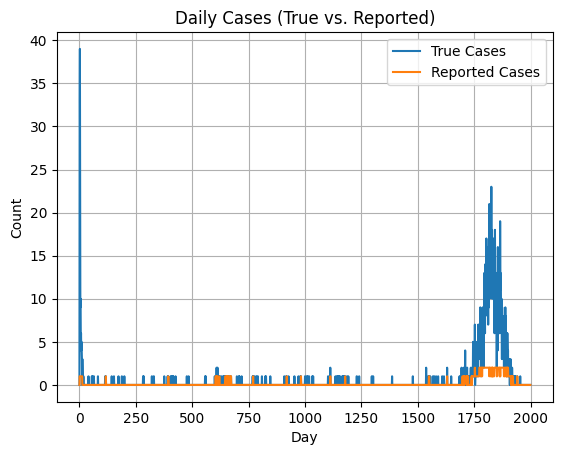

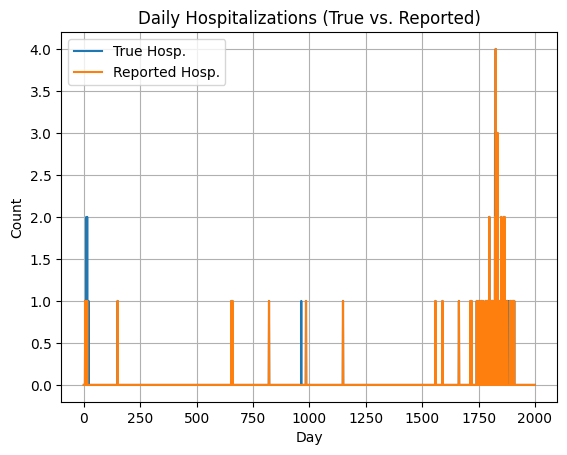

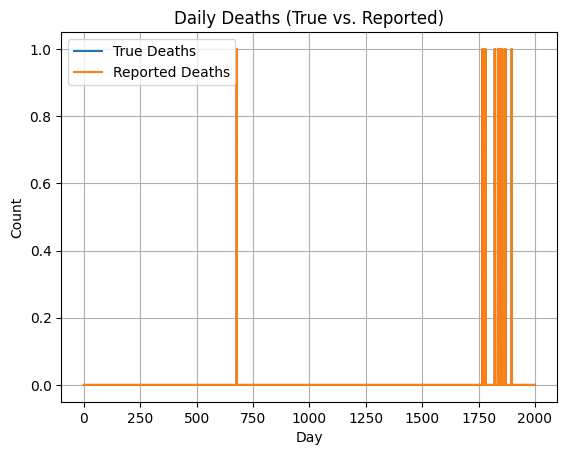

=== Sample 2 ===
  Population: 31438572
  Final compartments: {'S': 26741726, 'E': 40461, 'I': 53634, 'A': 0, 'R': 3874594}
  Final day of true new cases: 10756
  Final day of reported new cases: 2547.0


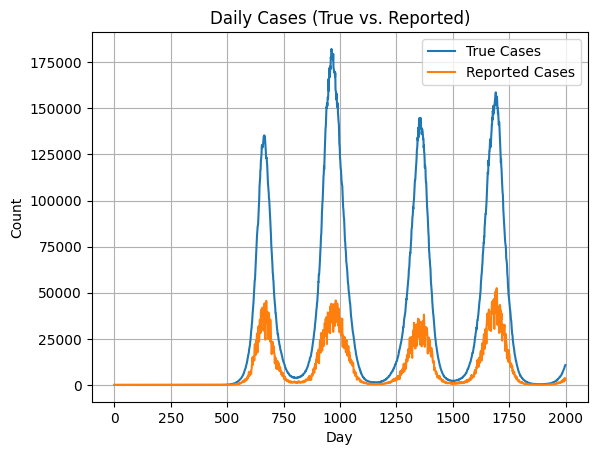

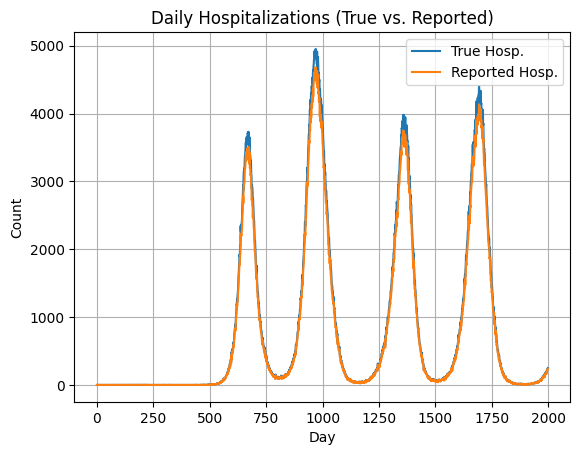

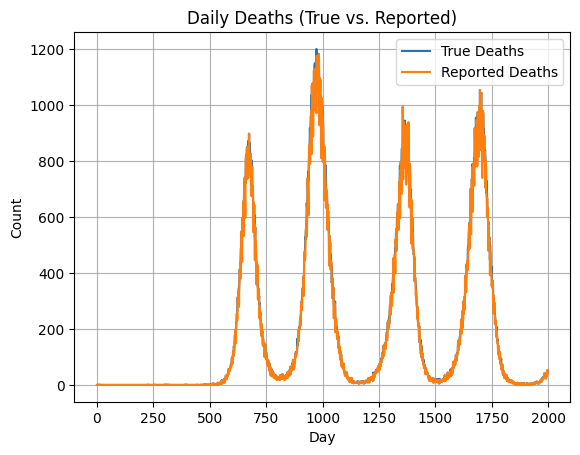

=== Sample 3 ===
  Population: 452252
  Final compartments: {'S': 452220, 'E': 0, 'I': 0, 'A': 0, 'R': 367}
  Final day of true new cases: 0
  Final day of reported new cases: 0.0


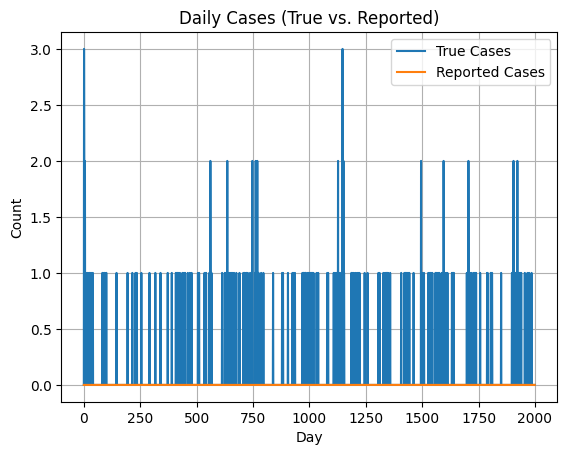

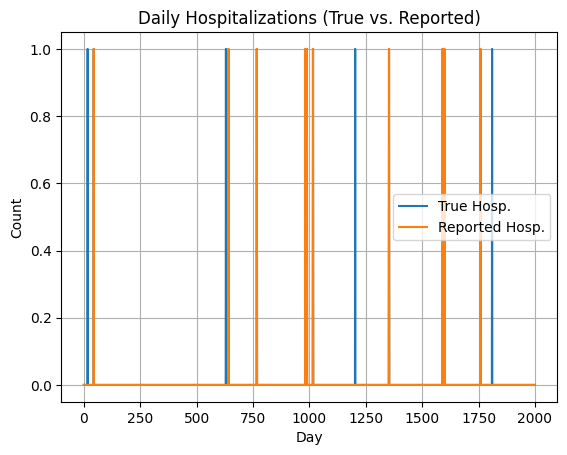

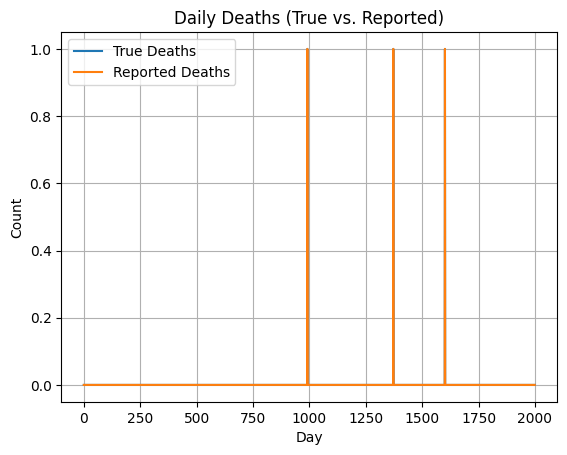

=== Sample 4 ===
  Population: 9197371
  Final compartments: {'S': 8945567, 'E': 1, 'I': 3, 'A': 0, 'R': 558}
  Final day of true new cases: 1
  Final day of reported new cases: 0.0


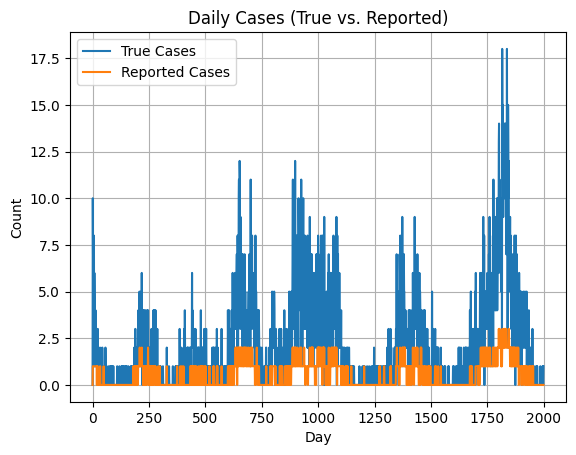

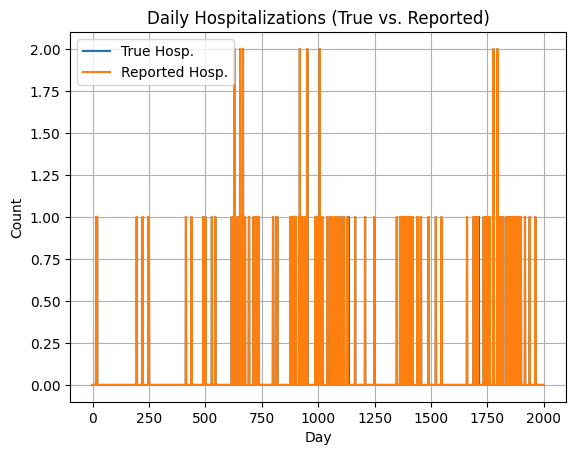

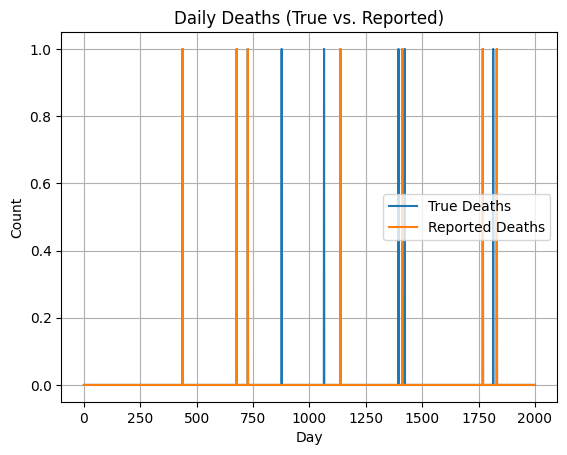

=== Sample 5 ===
  Population: 695150
  Final compartments: {'S': 672692, 'E': 22, 'I': 0, 'A': 0, 'R': 25}
  Final day of true new cases: 0
  Final day of reported new cases: 0.0


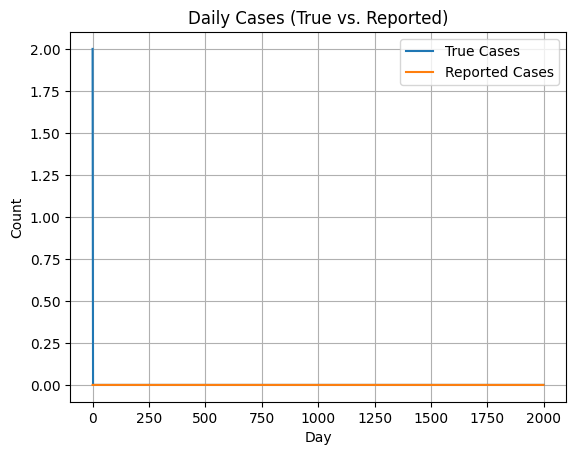

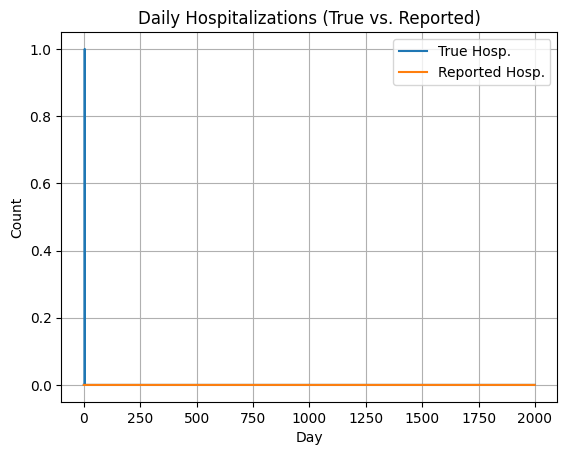

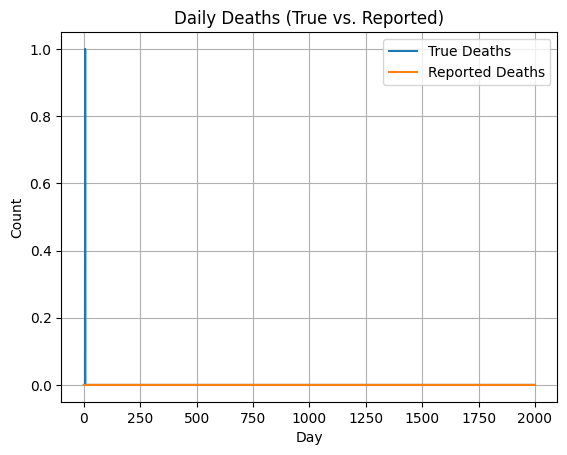

Test data generation completed successfully!


In [ ]:
test_data_generation()

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import time
from pathlib import Path
from google.colab import drive

def generate_and_save_disease_dataset_01(
    num_samples_needed=10000,
    output_filename='disease_dataset_01.csv'
):
    """
    Generate exactly `num_samples_needed` valid 2,000-day outbreaks
    (≥100 total reported cases), then save as `disease_dataset_01.csv`.

    Assumes that:
      - The UniversalDiseaseConfig, HumanToHumanSimulator, generate_synthetic_dataset,
        and all related classes/functions already exist in the environment.
      - We want to store only the reported daily new cases, hospitalizations,
        and deaths for each simulation.
      - is_waterborne and is_vectorborne are always set to 0 in our final data.
    """

    # 1) Mount drive
    drive.mount('/content/drive')

    config = UniversalDiseaseConfig(num_days=2000)  # set to 2000 days

    # 3) Prepare to gather valid runs
    valid_runs = []
    # We'll generate in batches to avoid extremely long single calls.
    batch_size = 2
    pbar = tqdm(total=num_samples_needed, desc="Collecting valid outbreaks")

    # 4) Keep generating batches until we have enough valid samples
    while len(valid_runs) < num_samples_needed:
        # Generate a batch of synthetic runs
        batch_data = generate_synthetic_dataset(config, num_samples=batch_size)
        # Filter by total reported cases
        for run in batch_data:
            total_reported_cases = sum(run["daily_new_cases_reported"])
            pop = run["population_size"]
            if total_reported_cases/pop >= 0.01:
                valid_runs.append(run)
                pbar.update(1)
                if len(valid_runs) == num_samples_needed:
                    break

    pbar.close()

    # 5) Build a DataFrame with reported data
    #    We'll have columns:
    #      - cases_day_<0..1999>
    #      - hosp_day_<0..1999>
    #      - death_day_<0..1999>
    #      - population
    #      - is_waterborne=0
    #      - is_vectorborne=0
    #    (We skip the "true" time series entirely.)

    # Initialize a dict for DataFrame columns
    df_cols = {}

    # Prep arrays for each portion (cases/hospital/death).
    # We'll store them as lists of lists, then build the columns.
    reported_cases_list = []
    reported_hosp_list = []
    reported_death_list = []
    pop_list = []

    for run in valid_runs:
        # Each run is a dictionary with e.g.:
        #   run["daily_new_cases_reported"]  => 2000-length list
        #   run["daily_hosp_reported"]       => 2000-length list
        #   run["daily_death_reported"]      => 2000-length list
        #   run["population_size"]           => int
        # etc.
        reported_cases_list.append(run["daily_new_cases_reported"])
        reported_hosp_list.append(run["daily_hosp_reported"])
        reported_death_list.append(run["daily_death_reported"])
        pop_list.append(run["population_size"])

    # Convert to arrays for easier column building
    reported_cases_array = np.array(reported_cases_list)   # shape: (N, 2000)
    reported_hosp_array = np.array(reported_hosp_list)     # shape: (N, 2000)
    reported_death_array = np.array(reported_death_list)   # shape: (N, 2000)

    # For each day i, create a column "cases_day_i", "hosp_day_i", "death_day_i"
    num_days = config.num_days  # 2000
    for i in range(num_days):
        df_cols[f"cases_day_{i}"] = reported_cases_array[:, i]
        df_cols[f"hosp_day_{i}"] = reported_hosp_array[:, i]
        df_cols[f"death_day_{i}"] = reported_death_array[:, i]

    # Also store population, plus is_waterborne=0 and is_vectorborne=0
    df_cols["population"] = pop_list
    df_cols["is_waterborne"] = 0
    df_cols["is_vectorborne"] = 0

    # Build DataFrame
    df = pd.DataFrame(df_cols)

    # 6) Save to CSV in the same Google Drive folder used before
    drive_path = "/content/drive/My Drive/disease_datasets"
    Path(drive_path).mkdir(parents=True, exist_ok=True)

    output_path = Path(drive_path) / output_filename
    df.to_csv(output_path, index=False)

    print(f"\n>>> Successfully saved {len(df)} valid outbreaks (≥100 reported cases) to:")
    print(f"    {output_path}")
    size_mb = output_path.stat().st_size / (1024*1024)
    print(f"    File size: {size_mb:.2f} MB")


In [4]:
generate_and_save_disease_dataset_01(
    num_samples_needed=10000,
    output_filename='disease_dataset_06.csv'
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



>>> Successfully saved 10000 valid outbreaks (≥100 reported cases) to:
    /content/drive/My Drive/disease_datasets/disease_dataset_06.csv
    File size: 280.97 MB


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['cases_day_0', 'hosp_day_0', 'death_day_0', 'cases_day_1', 'hosp_day_1',
       'death_day_1', 'cases_day_2', 'hosp_day_2', 'death_day_2',
       'cases_day_3',
       ...
       'death_day_1997', 'cases_day_1998', 'hosp_day_1998', 'death_day_1998',
       'cases_day_1999', 'hosp_day_1999', 'death_day_1999', 'population',
       'is_waterborne', 'is_vectorborne'],
      dtype='object', length=6003)
Sample 0 -> Population: 12446895.0


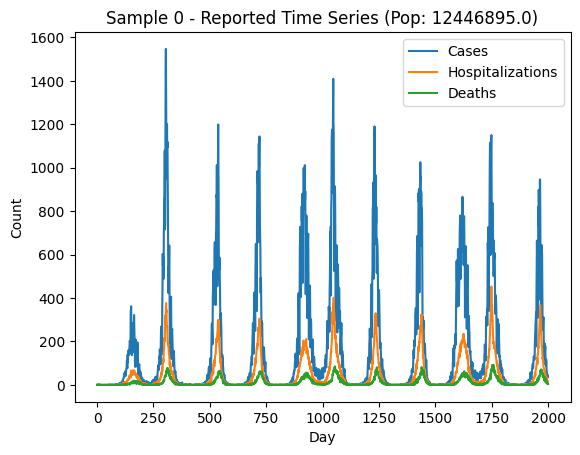

Sample 1 -> Population: 140213.0


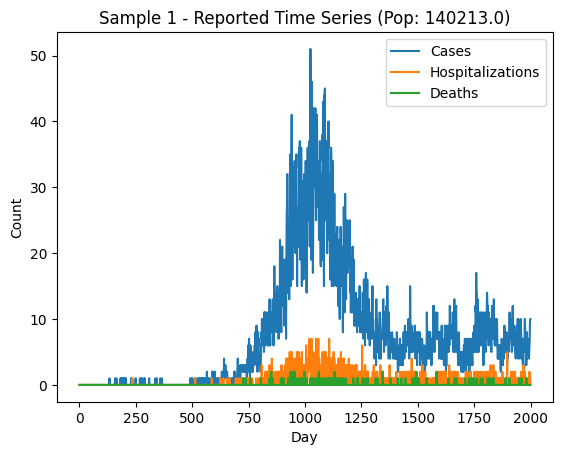

Sample 2 -> Population: 15505791.0


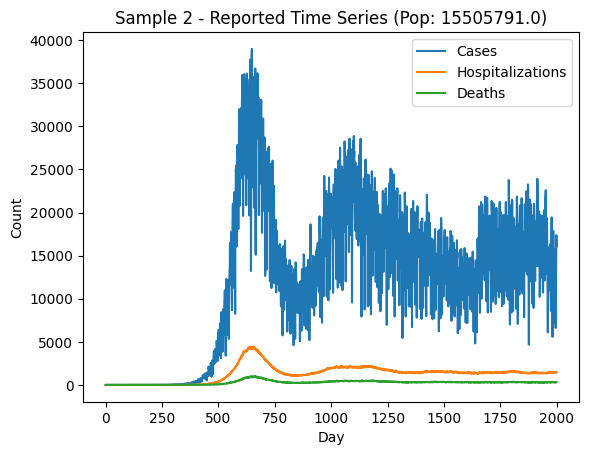

Sample 3 -> Population: 32884430.0


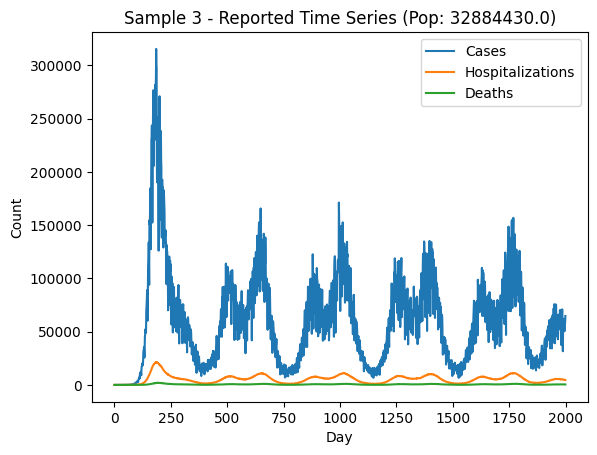

Sample 4 -> Population: 30780372.0


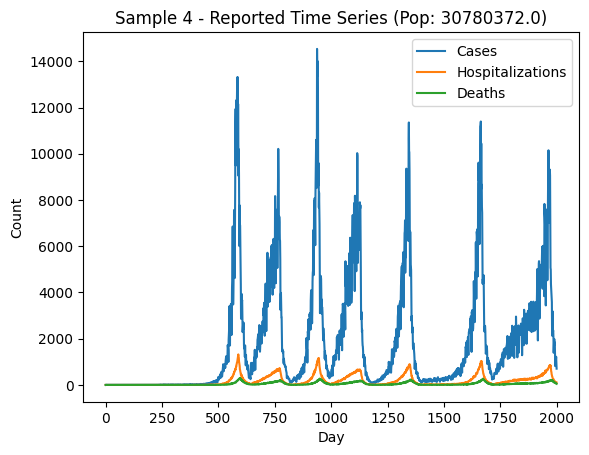

Sample 5 -> Population: 2795105.0


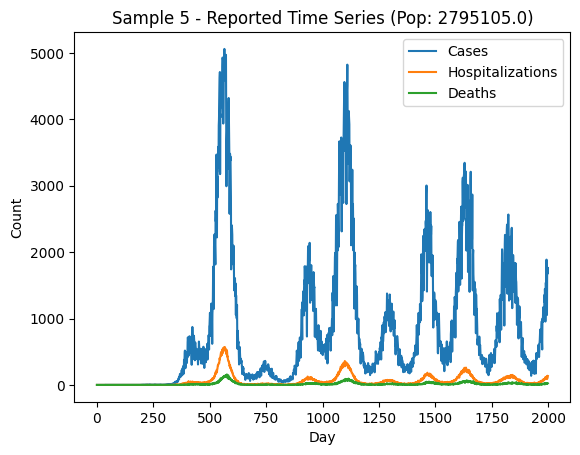

Sample 6 -> Population: 98289.0


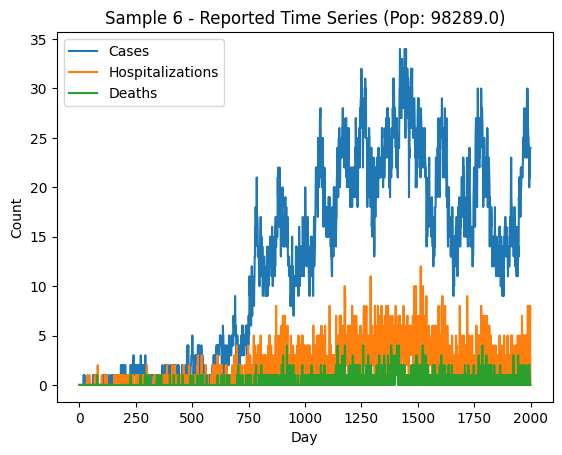

Sample 7 -> Population: 58994.0


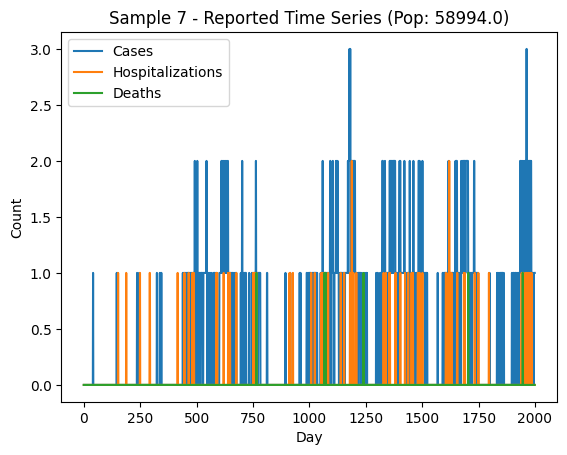

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

def inspect_first_three_samples(csv_path="/content/drive/My Drive/disease_datasets/disease_dataset_01.csv"):
    # 1) Load the dataset
    df = pd.read_csv(csv_path)
    print(df.columns)

    # Identify how many days we have by checking the column pattern
    day_columns_cases = [col for col in df.columns if col.startswith("cases_day_")]
    day_columns_hosp = [col for col in df.columns if col.startswith("hosp_day_")]
    day_columns_deaths = [col for col in df.columns if col.startswith("death_day_")]

    # 2) For the first 3 examples
    for i in range(8):
        # Extract the row i
        row = df.iloc[i]

        # Print population for this sample
        population_size = row["population"]
        print(f"Sample {i} -> Population: {population_size}")

        # Convert time-series columns to arrays
        daily_cases = row[day_columns_cases].to_numpy()
        daily_hosp = row[day_columns_hosp].to_numpy()
        daily_deaths = row[day_columns_deaths].to_numpy()

        # 3) Plot each time-series
        plt.figure()
        plt.plot(daily_cases, label="Cases")
        plt.plot(daily_hosp, label="Hospitalizations")
        plt.plot(daily_deaths, label="Deaths")
        plt.title(f"Sample {i} - Reported Time Series (Pop: {population_size})")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.show()

# Example usage:
inspect_first_three_samples()